<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/TStool/models_nhits__nhits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
! pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 8.3 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 585 kB 69.4 MB/s 
     |████████████████████████████████| 596 kB 60.2 MB/s 
     |████████████████████████████████| 140 kB 72.4 MB/s 
     |████████████████████████████████| 419 kB 72.7 MB/s 
     |████████████████████████████████| 1.1 MB 57.3 MB/s 
     |████████████████████████████████| 271 kB 75.8 MB/s 
     |████████████████████████████████| 144 kB 73.6 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 2.3 MB 57.9 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 357 kB 55.0 MB/s 
     |████████████████████████████████| 2.4 MB 50.8 MB/s 
     |████████████████████████████████| 138 kB 74.2 MB/s 
     |████████████████████████████████

In [3]:
#export
import math
import random
from functools import partial
from typing import Tuple, List
from fastcore.foundation import patch

import numpy as np
import pandas as pd
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import pytorch_lightning as pl

from neuralforecast.models.components.tcn import _TemporalConvNet
from neuralforecast.models.components.common import Chomp1d, RepeatVector
from neuralforecast.losses.utils import LossFunction
from neuralforecast.data.tsdataset import WindowsDataset
from neuralforecast.data.tsloader import TimeSeriesLoader

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#export
class _StaticFeaturesEncoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(_StaticFeaturesEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.encoder(x)
        return x

class _sEncoder(nn.Module):
    def __init__(self, in_features, out_features, n_time_in):
        super(_sEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)
        self.repeat = RepeatVector(repeats=n_time_in)
    
    def forward(self, x):
        # Encode and repeat values to match time
        x = self.encoder(x)
        x = self.repeat(x) # [N,S_out] -> [N,S_out,T]
        return x

In [5]:
#export
class _IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int, interpolation_mode: str):
        super().__init__()
        assert (interpolation_mode in ['linear','nearest']) or ('cubic' in interpolation_mode)
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
        self.interpolation_mode = interpolation_mode
 
    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:

        backcast = theta[:, :self.backcast_size]
        knots = theta[:, self.backcast_size:]

        if self.interpolation_mode=='nearest':
            knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            forecast = forecast[:,0,:]
        elif self.interpolation_mode=='linear':
            knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            forecast = forecast[:,0,:]
        elif 'cubic' in self.interpolation_mode:
            batch_size = len(backcast)
            knots = knots[:,None,None,:]
            forecast = t.zeros((len(knots), self.forecast_size)).to(knots.device)
            n_batches = int(np.ceil(len(knots)/batch_size))
            for i in range(n_batches):
                forecast_i = F.interpolate(knots[i*batch_size:(i+1)*batch_size], size=self.forecast_size, mode='bicubic')
                forecast[i*batch_size:(i+1)*batch_size] += forecast_i[:,0,0,:]

        return backcast, forecast

In [6]:
#export
class _ExogenousBasisInterpretable(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis = insample_x_t
        forecast_basis = outsample_x_t

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

class _ExogenousBasisWavenet(nn.Module):
    def __init__(self, out_features, in_features, num_levels=4, kernel_size=3, dropout_prob=0):
        super().__init__()
        # Shape of (1, in_features, 1) to broadcast over b and t
        self.weight = nn.Parameter(t.Tensor(1, in_features, 1), requires_grad=True)
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(0.5))

        padding = (kernel_size - 1) * (2**0)
        input_layer = [nn.Conv1d(in_channels=in_features, out_channels=out_features,
                                 kernel_size=kernel_size, padding=padding, dilation=2**0),
                                 Chomp1d(padding),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_prob)]
        conv_layers = []
        for i in range(1, num_levels):
            dilation = 2**i
            padding = (kernel_size - 1) * dilation
            conv_layers.append(nn.Conv1d(in_channels=out_features, out_channels=out_features,
                                         padding=padding, kernel_size=3, dilation=dilation))
            conv_layers.append(Chomp1d(padding))
            conv_layers.append(nn.ReLU())
        conv_layers = input_layer + conv_layers

        self.wavenet = nn.Sequential(*conv_layers)
        
    def transform(self, insample_x_t, outsample_x_t):
        n_time_in = insample_x_t.shape[2]
        
        x_t = t.cat([insample_x_t, outsample_x_t], dim=2)
        
        x_t = x_t * self.weight # Element-wise multiplication, broadcasted on b and t. Weights used in L1 regularization
        x_t = self.wavenet(x_t)[:]

        backcast_basis = x_t[:,:, :n_time_in]
        forecast_basis = x_t[:,:, n_time_in:]

        return backcast_basis, forecast_basis

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis, forecast_basis = self.transform(insample_x_t, outsample_x_t)

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

class _ExogenousBasisTCN(nn.Module):
    def __init__(self, out_features, in_features, num_levels = 4, kernel_size=2, dropout_prob=0):
        super().__init__()
        n_channels = num_levels * [out_features]
        self.tcn = _TemporalConvNet(num_inputs=in_features, num_channels=n_channels, kernel_size=kernel_size, dropout=dropout_prob)
        
    def transform(self, insample_x_t, outsample_x_t):
        n_time_in = insample_x_t.shape[2]
        
        x_t = t.cat([insample_x_t, outsample_x_t], dim=2)
        
        x_t = self.tcn(x_t)[:]
        backcast_basis = x_t[:,:, :n_time_in]
        forecast_basis = x_t[:,:, n_time_in:]

        return backcast_basis, forecast_basis

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis, forecast_basis = self.transform(insample_x_t, outsample_x_t)

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

In [7]:
#export
def _init_weights(module, initialization):
    if type(module) == t.nn.Linear:
        if initialization == 'orthogonal':
            t.nn.init.orthogonal_(module.weight)
        elif initialization == 'he_uniform':
            t.nn.init.kaiming_uniform_(module.weight)
        elif initialization == 'he_normal':
            t.nn.init.kaiming_normal_(module.weight)
        elif initialization == 'glorot_uniform':
            t.nn.init.xavier_uniform_(module.weight)
        elif initialization == 'glorot_normal':
            t.nn.init.xavier_normal_(module.weight)
        elif initialization == 'lecun_normal':
            pass #t.nn.init.normal_(module.weight, 0.0, std=1/np.sqrt(module.weight.numel()))
        else:
            assert 1<0, f'Initialization {initialization} not found'

In [8]:
#export
ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

class _NHITSBlock(nn.Module):
    """
    N-BEATS block which takes a basis function as an argument.
    """
    def __init__(self, n_time_in: int, n_time_out: int, n_x: int,
                 n_s: int, n_s_hidden: int, n_theta: int, n_mlp_units: list,
                 n_pool_kernel_size: int, pooling_mode: str, basis: nn.Module,
                 n_layers: int,  batch_normalization: bool, dropout_prob: float, activation: str):
        """
        """
        super().__init__()

        assert (pooling_mode in ['max','average'])

        n_time_in_pooled = int(np.ceil(n_time_in/n_pool_kernel_size))

        if n_s == 0:
            n_s_hidden = 0
        n_mlp_units = [n_time_in_pooled + (n_time_in+n_time_out)*n_x + n_s_hidden] + n_mlp_units
        
        self.n_time_in = n_time_in
        self.n_time_out = n_time_out
        self.n_s = n_s
        self.n_s_hidden = n_s_hidden
        self.n_x = n_x
        self.n_pool_kernel_size = n_pool_kernel_size
        self.batch_normalization = batch_normalization
        self.dropout_prob = dropout_prob
        
        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        activ = getattr(nn, activation)()

        if pooling_mode == 'max':
            self.pooling_layer = nn.MaxPool1d(kernel_size=self.n_pool_kernel_size,
                                              stride=self.n_pool_kernel_size, ceil_mode=True)
        elif pooling_mode == 'average':
            self.pooling_layer = nn.AvgPool1d(kernel_size=self.n_pool_kernel_size,
                                              stride=self.n_pool_kernel_size, ceil_mode=True)

        hidden_layers = []
        for i in range(n_layers):
            hidden_layers.append(nn.Linear(in_features=n_mlp_units[i], out_features=n_mlp_units[i+1]))
            hidden_layers.append(activ)

            if self.batch_normalization:
                hidden_layers.append(nn.BatchNorm1d(num_features=n_mlp_units[i+1]))

            if self.dropout_prob>0:
                hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=n_mlp_units[-1], out_features=n_theta)]
        layers = hidden_layers + output_layer

        # n_s is computed with data, n_s_hidden is provided by user, if 0 no statics are used
        if (self.n_s > 0) and (self.n_s_hidden > 0):
            self.static_encoder = _StaticFeaturesEncoder(in_features=n_s, out_features=n_s_hidden)
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: t.Tensor, insample_x_t: t.Tensor,
                outsample_x_t: t.Tensor, x_s: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:

        insample_y = insample_y.unsqueeze(1)
        insample_y = self.pooling_layer(insample_y)
        insample_y = insample_y.squeeze(1)

        batch_size = len(insample_y)
        if self.n_x > 0:
            insample_y = t.cat(( insample_y, insample_x_t.reshape(batch_size, -1) ), 1)
            insample_y = t.cat(( insample_y, outsample_x_t.reshape(batch_size, -1) ), 1)
        
        # Static exogenous
        if (self.n_s > 0) and (self.n_s_hidden > 0):
            x_s = self.static_encoder(x_s)
            insample_y = t.cat((insample_y, x_s), 1)

        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta, insample_x_t, outsample_x_t)

        return backcast, forecast

In [9]:
#export
class _NHITS(nn.Module):
    """
    NHITS Model.
    """
    def __init__(self, 
                 n_time_in,
                 n_time_out,
                 n_s,
                 n_x,
                 n_s_hidden,
                 n_x_hidden,
                 stack_types: list,
                 n_blocks: list,
                 n_layers: list,
                 n_mlp_units: list,
                 n_pool_kernel_size: list,
                 n_freq_downsample: list,
                 pooling_mode,
                 interpolation_mode,
                 dropout_prob_theta,
                 activation,
                 initialization,
                 batch_normalization,
                 shared_weights):
        super().__init__()

        self.n_time_out = n_time_out

        blocks = self.create_stack(stack_types=stack_types, 
                                   n_blocks=n_blocks,
                                   n_time_in=n_time_in,
                                   n_time_out=n_time_out,
                                   n_x=n_x,
                                   n_x_hidden=n_x_hidden,
                                   n_s=n_s,
                                   n_s_hidden=n_s_hidden,
                                   n_layers=n_layers,
                                   n_mlp_units=n_mlp_units,
                                   n_pool_kernel_size=n_pool_kernel_size,
                                   n_freq_downsample=n_freq_downsample,
                                   pooling_mode=pooling_mode,
                                   interpolation_mode=interpolation_mode,
                                   batch_normalization=batch_normalization,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation,
                                   shared_weights=shared_weights,
                                   initialization=initialization)
        self.blocks = t.nn.ModuleList(blocks)

    def create_stack(self, stack_types, n_blocks, 
                     n_time_in, n_time_out, 
                     n_x, n_x_hidden, n_s, n_s_hidden, 
                     n_layers, n_mlp_units, 
                     n_pool_kernel_size, n_freq_downsample, pooling_mode, interpolation_mode,
                     batch_normalization, dropout_prob_theta, 
                     activation, shared_weights, initialization):                     
        block_list = []
        for i in range(len(stack_types)):
            assert stack_types[i] in ['identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'], 'f Invalid stack type {stack_types[i]}'
            for block_id in range(n_blocks[i]):
                
                # Batch norm only on first block
                if (len(block_list)==0) and (batch_normalization):
                    batch_normalization_block = True
                else:
                    batch_normalization_block = False

                # Shared weights
                if shared_weights and block_id>0:
                    nbeats_block = block_list[-1]
                else:
                    if stack_types[i] == 'identity':
                        n_theta = (n_time_in + max(n_time_out//n_freq_downsample[i], 1) )
                        basis = _IdentityBasis(backcast_size=n_time_in,
                                              forecast_size=n_time_out,
                                              interpolation_mode=interpolation_mode)                        

                    elif stack_types[i] == 'exogenous':
                        n_theta = 2 * n_x
                        basis = _ExogenousBasisInterpretable()

                    elif stack_types[i] == 'exogenous_tcn':
                        n_theta = 2 * n_x_hidden
                        basis = _ExogenousBasisTCN(n_x_hidden, n_x)

                    elif stack_types[i] == 'exogenous_wavenet':
                        n_theta = 2 * n_x_hidden
                        basis = _ExogenousBasisWavenet(n_x_hidden, n_x)

                    nbeats_block = _NHITSBlock(n_time_in=n_time_in,
                                               n_time_out=n_time_out,
                                               n_x=n_x,
                                               n_s=n_s,
                                               n_s_hidden=n_s_hidden,
                                               n_theta=n_theta,
                                               n_mlp_units=n_mlp_units[i],
                                               n_pool_kernel_size=n_pool_kernel_size[i],
                                               pooling_mode=pooling_mode,
                                               basis=basis,
                                               n_layers=n_layers[i],
                                               batch_normalization=batch_normalization_block,
                                               dropout_prob=dropout_prob_theta,
                                               activation=activation)

                # Select type of evaluation and apply it to all layers of block
                init_function = partial(_init_weights, initialization=initialization)                                             
                nbeats_block.layers.apply(init_function)
                block_list.append(nbeats_block)
        return block_list

    def forward(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor, 
                insample_mask: t.Tensor, outsample_mask: t.Tensor,
                return_decomposition: bool=False):
        
        # insample
        insample_y    = Y[:, :-self.n_time_out]
        insample_x_t  = X[:, :, :-self.n_time_out]
        insample_mask = insample_mask[:, :-self.n_time_out]
        
        # outsample
        outsample_y   = Y[:, -self.n_time_out:]
        outsample_x_t = X[:, :, -self.n_time_out:]
        outsample_mask = outsample_mask[:, -self.n_time_out:]

        if return_decomposition:
            forecast, block_forecasts = self.forecast_decomposition(insample_y=insample_y, 
                                                                    insample_x_t=insample_x_t, 
                                                                    insample_mask=insample_mask,
                                                                    outsample_x_t=outsample_x_t,
                                                                    x_s=S)
            return outsample_y, forecast, block_forecasts, outsample_mask
        
        else:
            forecast = self.forecast(insample_y=insample_y,
                                     insample_x_t=insample_x_t, 
                                     insample_mask=insample_mask,
                                     outsample_x_t=outsample_x_t,
                                     x_s=S)
            return outsample_y, forecast, outsample_mask

    def forecast(self, insample_y: t.Tensor, insample_x_t: t.Tensor, insample_mask: t.Tensor,
                 outsample_x_t: t.Tensor, x_s: t.Tensor):

        residuals = insample_y.flip(dims=(-1,))
        insample_x_t = insample_x_t.flip(dims=(-1,))
        insample_mask = insample_mask.flip(dims=(-1,))

        forecast = insample_y[:, -1:] # Level with Naive1
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, insample_x_t=insample_x_t,
                                             outsample_x_t=outsample_x_t, x_s=x_s)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast

        return forecast

    def forecast_decomposition(self, insample_y: t.Tensor, insample_x_t: t.Tensor, insample_mask: t.Tensor,
                               outsample_x_t: t.Tensor, x_s: t.Tensor):

        residuals = insample_y.flip(dims=(-1,))
        insample_x_t = insample_x_t.flip(dims=(-1,))
        insample_mask = insample_mask.flip(dims=(-1,))
        
        n_batch, n_channels, n_t = outsample_x_t.size(0), outsample_x_t.size(1), outsample_x_t.size(2)
        
        level = insample_y[:, -1:] # Level with Naive1
        block_forecasts = [ level.repeat(1, n_t) ]
                
        forecast = level
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, insample_x_t=insample_x_t,
                                             outsample_x_t=outsample_x_t, x_s=x_s)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast
            block_forecasts.append(block_forecast)
            
        # (n_batch, n_blocks, n_t)
        block_forecasts = t.stack(block_forecasts)
        block_forecasts = block_forecasts.permute(1,0,2)

        return forecast, block_forecasts

In [10]:
#export
class NHITS(pl.LightningModule):
    def __init__(self,
                 n_time_in: int,
                 n_time_out: int,
                 n_x: int,
                 n_s: int,
                 shared_weights: bool,
                 activation: str,
                 initialization: str,
                 stack_types: List[str],
                 n_blocks: List[int],
                 n_layers: List[int],
                 n_mlp_units: List[List[int]],
                 n_x_hidden: int,
                 n_s_hidden: int,
                 n_pool_kernel_size: List[int],
                 n_freq_downsample: List[int],
                 pooling_mode: str,
                 interpolation_mode: str,
                 batch_normalization: bool,
                 dropout_prob_theta: float,
                 learning_rate: float,
                 lr_decay: float,
                 lr_decay_step_size: int,
                 weight_decay: float,
                 loss_train: str,
                 loss_hypar: float,
                 loss_valid: str,
                 frequency: str,
                 random_seed: int):
        """
        N-HiTS model.

            Parameters
            ----------
            n_time_in: int
                Multiplier to get insample size.
                Insample size = n_time_in * output_size
            n_time_out: int
                Forecast horizon.
            n_x: int
                Number of exogenous variables.
            n_s: int
                Number of static variables.
            shared_weights: bool
                If True, all blocks within each stack will share parameters.
            activation: str
                Activation function.
                An item from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].
            initialization: str
                Initialization function.
                An item from ['orthogonal', 'he_uniform', 'glorot_uniform', 'glorot_normal', 'lecun_normal'].
            stack_types: List[str]
                List of stack types.
                Subset from ['seasonality', 'trend', 'identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'].
            n_blocks: List[int]
                Number of blocks for each stack.
                Note that len(n_blocks) = len(stack_types).
            n_layers: List[int]
                Number of layers for each stack type.
                Note that len(n_layers) = len(stack_types).
            n_mlp_units: List[List[int]]
                Structure of hidden layers for each stack type.
                Each internal list should contain the number of units of each hidden layer.
                Note that len(n_hidden) = len(stack_types).
            n_x_hidden: int
                Number of hidden output channels of exogenous_tcn and exogenous_wavenet stacks. 
            n_s_hidden: int
                Number of encoded static features, output dim of _StaticFeaturesEncoder. 
            n_pool_kernel_size List[int]:
                Pooling size for input for each stack.
                Note that len(n_pool_kernel_size) = len(stack_types).
            n_freq_downsample List[int]:
                Downsample multiplier of output for each stack. Expressivity ratio (r) = 1/n_freq_downsample
                Note that len(n_freq_downsample) = len(stack_types).
            pooling_mode: str
                Pooling type.
                An item from ['average', 'max']
            interpolation_mode: str
                Interpolation function.
                An item from ['linear', 'nearest', 'cubic']
            batch_normalization: bool
                Whether perform batch normalization.
            dropout_prob_theta: float
                Float between (0, 1).
                Dropout for Nbeats basis.
            learning_rate: float
                Learning rate between (0, 1).
            lr_decay: float
                Decreasing multiplier for the learning rate.
            lr_decay_step_size: int
                Steps between each learning rate decay.
            weight_decay: float
                L2 penalty for optimizer.
            loss_train: str
                Loss to optimize.
                An item from ['MAPE', 'MASE', 'SMAPE', 'MSE', 'MAE', 'QUANTILE', 'QUANTILE2'].
            loss_hypar: float
                Hyperparameter for chosen loss.
            loss_valid: str
                Validation loss.
                An item from ['MAPE', 'MASE', 'SMAPE', 'RMSE', 'MAE', 'QUANTILE'].
            frequency: str
                Time series frequency.
            random_seed: int
                random_seed for pseudo random pytorch initializer and
                numpy random generator.
        """
        
        super(NHITS, self).__init__()
        self.save_hyperparameters()
        
        if activation == 'SELU': initialization = 'lecun_normal'

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.n_time_in = n_time_in
        self.n_time_out = n_time_out
        self.n_x = n_x
        self.n_x_hidden = n_x_hidden
        self.n_s = n_s
        self.n_s_hidden = n_s_hidden
        self.shared_weights = shared_weights
        self.activation = activation
        self.initialization = initialization
        self.stack_types = stack_types
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.n_mlp_units = n_mlp_units
        self.n_pool_kernel_size = n_pool_kernel_size
        self.n_freq_downsample = n_freq_downsample
        self.pooling_mode = pooling_mode
        self.interpolation_mode = interpolation_mode

        # Loss functions
        self.loss_train = loss_train
        self.loss_hypar = loss_hypar
        self.loss_valid = loss_valid
        self.loss_fn_train = LossFunction(loss_train,
                                          percentile=self.loss_hypar,
                                          seasonality=self.loss_hypar)
        self.loss_fn_valid = LossFunction(loss_valid,
                                          percentile=self.loss_hypar,
                                          seasonality=self.loss_hypar)
        
        # Regularization and optimization parameters
        self.batch_normalization = batch_normalization
        self.dropout_prob_theta = dropout_prob_theta        
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.weight_decay = weight_decay
        self.lr_decay_step_size = lr_decay_step_size
        self.random_seed = random_seed

        # Data parameters
        self.frequency = frequency
        self.return_decomposition = False

        self.model = _NHITS(n_time_in=self.n_time_in,
                            n_time_out=self.n_time_out,
                            n_s=self.n_s,
                            n_x=self.n_x,
                            n_s_hidden=self.n_s_hidden,
                            n_x_hidden=self.n_x_hidden,
                            stack_types=self.stack_types,
                            n_blocks=self.n_blocks,
                            n_layers=self.n_layers,
                            n_mlp_units=self.n_mlp_units,
                            n_pool_kernel_size=self.n_pool_kernel_size,
                            n_freq_downsample=self.n_freq_downsample,
                            pooling_mode=self.pooling_mode,
                            interpolation_mode=self.interpolation_mode,
                            dropout_prob_theta=self.dropout_prob_theta,
                            activation=self.activation,
                            initialization=self.initialization,
                            batch_normalization=self.batch_normalization,
                            shared_weights=self.shared_weights)

    def training_step(self, batch, batch_idx):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        outsample_y, forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                           insample_mask=available_mask,
                                                           outsample_mask=sample_mask,
                                                           return_decomposition=False)

        loss = self.loss_fn_train(y=outsample_y,
                                  y_hat=forecast,
                                  mask=outsample_mask,
                                  y_insample=Y)

        self.log('train_loss', loss, prog_bar=True, on_epoch=True)

        return loss

    def validation_step(self, batch, idx):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        outsample_y, forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                           insample_mask=available_mask,
                                                           outsample_mask=sample_mask,
                                                           return_decomposition=False)

        loss = self.loss_fn_valid(y=outsample_y,
                                  y_hat=forecast,
                                  mask=outsample_mask,
                                  y_insample=Y)

        self.log('val_loss', loss, prog_bar=True)
        
        return loss

    def on_fit_start(self):
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

    def forward(self, batch):
        S = batch['S']
        Y = batch['Y']
        X = batch['X']
        ts_idxs = batch['ts_idxs']
        sample_mask = batch['sample_mask']
        available_mask = batch['available_mask']

        if self.return_decomposition:
            outsample_y, forecast, block_forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                                     insample_mask=available_mask,
                                                                     outsample_mask=sample_mask,
                                                                     return_decomposition=True)
            return outsample_y, forecast, block_forecast, outsample_mask

        outsample_y, forecast, outsample_mask = self.model(S=S, Y=Y, X=X,
                                                           insample_mask=available_mask,
                                                           outsample_mask=sample_mask,
                                                           return_decomposition=False)
        return outsample_y, forecast, outsample_mask, ts_idxs

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(),
                               lr=self.learning_rate, 
                               weight_decay=self.weight_decay)
        
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                                 step_size=self.lr_decay_step_size, 
                                                 gamma=self.lr_decay)

        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}
     

In [ ]:
#export
@patch
def forecast(self: NHITS, Y_df: pd.DataFrame, X_df: pd.DataFrame = None, S_df: pd.DataFrame = None, 
             batch_size: int =1, trainer: pl.Trainer = None,
             verbose: bool = False) -> pd.DataFrame:
    """
    Method for forecasting self.n_time_out periods after last timestamp of Y_df.

    Parameters
    ----------
    Y_df: pd.DataFrame
        Dataframe with target time-series data, needs 'unique_id','ds' and 'y' columns.
    X_df: pd.DataFrame
        Dataframe with exogenous time-series data, needs 'unique_id' and 'ds' columns.
        Note that 'unique_id' and 'ds' must match Y_df plus the forecasting horizon.
    S_df: pd.DataFrame
        Dataframe with static data, needs 'unique_id' column.
    batch_size: int
        Batch size for forecasting.
    trainer: pl.Trainer
        Trainer object for model training and evaluation.
    verbose: bool
        Print dataset information.

    Returns
    ----------
    forecast_df: pd.DataFrame
        Dataframe with forecasts.
    """
    
    # Add forecast dates to Y_df
    Y_df = Y_df.reset_index(drop=True)
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])
    if X_df is not None:
        X_df = X_df.reset_index(drop=True)
        X_df['ds'] = pd.to_datetime(X_df['ds'])
    forecast_dates = pd.date_range(Y_df['ds'].max(), periods=self.n_time_out+1, freq=self.frequency)[1:]
    index = pd.MultiIndex.from_product([Y_df['unique_id'].unique(), forecast_dates], names=['unique_id', 'ds'])
    forecast_df = pd.DataFrame({'y':[0]}, index=index).reset_index()

    Y_df = Y_df.append(forecast_df).sort_values(['unique_id','ds']).reset_index(drop=True)

    # Dataset, loader and trainer
    dataset = WindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                mask_df=None, f_cols=[],
                                input_size=self.n_time_in,
                                output_size=self.n_time_out,
                                sample_freq=1,
                                complete_windows=True,
                                ds_in_test=self.n_time_out,
                                is_test=True,
                                verbose=verbose)

    loader = TimeSeriesLoader(dataset=dataset,
                                batch_size=batch_size,
                                shuffle=False)

    if trainer is None:
        gpus = -1 if t.cuda.is_available() else 0
        trainer = pl.Trainer(progress_bar_refresh_rate=1,
                             gpus=gpus,
                             logger=False)

    # Forecast
    outputs = trainer.predict(self, loader)

    # Process forecast and include in forecast_df
    _, forecast, _, _ = [t.cat(output).cpu().numpy() for output in zip(*outputs)]
    forecast_df['y'] = forecast.flatten()

    return forecast_df

In [11]:
#export
@patch
def predict(self: NHITS, Y_df: pd.DataFrame, X_df: pd.DataFrame = None, S_df: pd.DataFrame = None, 
            batch_size: int=1, trainer: pl.Trainer = None,
            verbose: bool = False) -> pd.DataFrame:
    """

    This function creates rolled predictions for historic `Y_df`, parses and outputs them
    in a long format `Y_hat_df` dataframe.
    
    This function does not returns forecasts outside Y_df dates.
    To get forecasts for future ds use the `forecast` method.

    Parameters
    ----------
        Y_df: pd.DataFrame
            Dataframe with target time-series data, needs 'unique_id','ds' and 'y' columns.
        X_df: pd.DataFrame
            Dataframe with exogenous time-series data, needs 'unique_id' and 'ds' columns.
            Note that 'unique_id' and 'ds' must match Y_df.
        S_df: pd.DataFrame
            Dataframe with static data, needs 'unique_id' column.
        bath_size: int
            Batch size for forecasting.
        trainer: pl.Trainer
            Trainer object for model training and evaluation.
        verbose: bool
            Print dataset information.

    Returns
    ----------
        Y_hat_df: pd.DataFrame
            Predictions DataFrame with columns:
            'unique_id': string/object series identifier
            'fcds': date stamps marking the forecast creation.
            'ds': prediction date stamps.
            'y': historic true values.
            'y_hat': forecasted values.
    """
    
    #------------------------------------- Model preds -------------------------------------#

    # Add forecast dates to Y_df
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])
    if X_df is not None:
        X_df['ds'] = pd.to_datetime(X_df['ds'])

    # Dataset, loader and trainer
    dataset = WindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                             mask_df=None, f_cols=[],
                             input_size=self.n_time_in,
                             output_size=self.n_time_out,
                             sample_freq=1,
                             complete_windows=True,
                             ds_in_test=0,
                             is_test=False,
                             verbose=True)

    loader = TimeSeriesLoader(dataset=dataset,
                              batch_size=batch_size,
                              shuffle=False)

    if trainer is None:
        gpus = -1 if t.cuda.is_available() else 0
        trainer = pl.Trainer(progress_bar_refresh_rate=1,
                             gpus=gpus,
                             logger=False)

    # Forecast all rolled windows
    outputs = trainer.predict(self, loader)

    y_true, y_hat, _, _ = [t.cat(output).cpu().numpy() for output in zip(*outputs)]

    #------------------------------------ ds Wrangling -------------------------------------#

    # Y_hat dataframe wrangling
    unique_ids = Y_df['unique_id'].unique()

    # Extend ds vector to match padded ts_tensor
    timedelta = dataset.ds[1] -dataset.ds[0]
    start_date = dataset.ds[0] - dataset.input_size*timedelta
    end_date = dataset.ds[-1] + dataset.output_size*timedelta
    ds = pd.date_range(start_date, end_date, freq=dataset.frequency)

    # Padded sample_mask to filter forecasted datestamps
    sample_mask = dataset.ts_tensor[:,dataset.t_cols.index('sample_mask'),:]
    padding = (self.n_time_in, self.n_time_out)
    padder = t.nn.ConstantPad1d(padding=padding, value=0)
    sample_mask = padder(sample_mask)

    # Create tensor with rolled date indexes and sample_mask
    # [n_series,n_channel,n_time_padded]->[n_series,n_channel,n_windows,L+H]
    ds_idxs = t.tile(t.arange(start=0, end=len(ds)), dims=[len(sample_mask), 1])
    windows_tensor = t.cat((sample_mask[:,None,:], ds_idxs[:,None,:]), dim=1)
    windows_tensor = windows_tensor.unfold(dimension=-1, 
                            size=self.n_time_in+self.n_time_out,
                            step=dataset.sample_freq) # For the moment sample_freq=1
    
    # Sampling condition, ALL ds in the forecast window should be sampleaple
    # [n_series,n_windows,L+H]->[n_series,n_windows]
    sample_mask_rolled = windows_tensor[:,0,:,-self.n_time_out:]
    sample_condition = (sample_mask_rolled.sum(dim=2)==self.n_time_out)

    # Use date indexes to create windows of date stamps
    # And filter the dates of the forecast and the forecast creation date 
    # with -self.n_time_out-1
    ds_rolled = ds[windows_tensor[:,1,:,-self.n_time_out-1:].numpy().astype(int)]     

    # Filter rolled ds with sample_condition
    ds_rolled = ds_rolled.reshape(-1, self.n_time_out+1)
    ds_rolled = ds_rolled[sample_condition.flatten()]

    # Split forecast creation date from the prediction ds
    fcds = ds_rolled[:,0]
    ds_rolled = ds_rolled[:,1:]

    #------------------------------------- Forecast df -------------------------------------#

    # Compute per series' observations = horizon * n_windows
    # and create unique_id column in long format
    unique_id_counts = self.n_time_out*sample_condition.sum(dim=1) # vectorized
    unique_ids_column = [[u_id]*count for u_id,count in zip(unique_ids, unique_id_counts)]
    unique_ids_column = np.concatenate(unique_ids_column)

    # Forecast creation date column in long format, shared across horizon
    fcds_column = fcds.repeat(self.n_time_out)

    # Output DataFrame
    Y_hat_df = pd.DataFrame({'unique_id':unique_ids_column,
                             'fcds': fcds_column,
                             'ds':ds_rolled.flatten(),
                             'y': y_true.flatten(),
                             'y_hat':y_hat.flatten()})

    return Y_hat_df

In [28]:
import pandas as pd
from neuralforecast.data.datasets.long_horizon import LongHorizon

from neuralforecast.data.tsloader import TimeSeriesLoader

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 19

Y_df, X_df, S_df = LongHorizon.load(directory='./data', group='ETTm2')


In [37]:
print(S_df)

None


In [29]:
X_df

,unique_id,ds,ex_1,ex_2,ex_3,ex_4
0,HUFL,2016-07-01 00:00:00,-0.500000,0.166667,-0.500000,-0.001370
1,HUFL,2016-07-01 00:15:00,-0.500000,0.166667,-0.500000,-0.001370
2,HUFL,2016-07-01 00:30:00,-0.500000,0.166667,-0.500000,-0.001370
3,HUFL,2016-07-01 00:45:00,-0.500000,0.166667,-0.500000,-0.001370
4,HUFL,2016-07-01 01:00:00,-0.456522,0.166667,-0.500000,-0.001370
...,...,...,...,...,...,...
403195,OT,2018-02-20 22:45:00,0.456522,-0.333333,0.133333,-0.363014
403196,OT,2018-02-20 23:00:00,0.500000,-0.333333,0.133333,-0.363014
403197,OT,2018-02-20 23:15:00,0.500000,-0.333333,0.133333,-0.363014
403198,OT,2018-02-20 23:30:00,0.500000,-0.333333,0.133333,-0.363014


In [27]:
X_df.unique_id.value_counts()

HUFL    57600
HULL    57600
LUFL    57600
LULL    57600
MUFL    57600
MULL    57600
OT      57600
Name: unique_id, dtype: int64

In [31]:
Y_df.unique_id.value_counts()

HUFL    57600
HULL    57600
LUFL    57600
LULL    57600
MUFL    57600
MULL    57600
OT      57600
Name: unique_id, dtype: int64

In [32]:
Y_df = Y_df[Y_df['unique_id'].isin(['HUFL','OT'])]
Y_df = Y_df[1000:] #?
Y_df = Y_df.reset_index(drop=True)
Y_df['y'] = range(len(Y_df)) 
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [16]:
Y_df.unique_id.value_counts()

OT      57600
HUFL    56600
Name: unique_id, dtype: int64

In [21]:
Y_df[Y_df['unique_id']=='OT']

,unique_id,ds,y
56600,OT,2016-07-01 00:00:00,56600
56601,OT,2016-07-01 00:15:00,56601
56602,OT,2016-07-01 00:30:00,56602
56603,OT,2016-07-01 00:45:00,56603
56604,OT,2016-07-01 01:00:00,56604
...,...,...,...
114195,OT,2018-02-20 22:45:00,114195
114196,OT,2018-02-20 23:00:00,114196
114197,OT,2018-02-20 23:15:00,114197
114198,OT,2018-02-20 23:30:00,114198


In [22]:
Y_df[Y_df['unique_id']=='HUFL'] 

,unique_id,ds,y
0,HUFL,2016-07-11 10:00:00,0
1,HUFL,2016-07-11 10:15:00,1
2,HUFL,2016-07-11 10:30:00,2
3,HUFL,2016-07-11 10:45:00,3
4,HUFL,2016-07-11 11:00:00,4
...,...,...,...
56595,HUFL,2018-02-20 22:45:00,56595
56596,HUFL,2018-02-20 23:00:00,56596
56597,HUFL,2018-02-20 23:15:00,56597
56598,HUFL,2018-02-20 23:30:00,56598


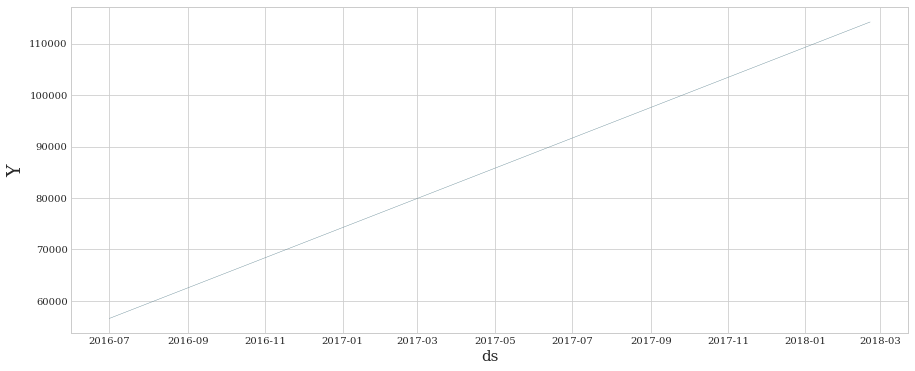

In [23]:
fig = plt.figure(figsize=(15, 6))
plt.plot(Y_df[Y_df['unique_id']=='OT'].ds, Y_df[Y_df['unique_id']=='OT'].y.values, color='#628793', linewidth=0.4)
plt.ylabel('Y', fontsize=19)
plt.xlabel('ds', fontsize=15)
plt.show()

In [33]:
96/15

6.4

In [24]:
# Architecture parameters
mc = {}
mc['model'] = 'n-hits'
mc['mode'] = 'simple'
mc['activation'] = 'ReLU'

mc['n_time_in'] = 96*2
mc['n_time_out'] = 96
mc['n_x_hidden'] = 8
mc['n_s_hidden'] = 0

mc['stack_types'] = ['identity', 'identity', 'identity']
mc['constant_n_blocks'] = 1
mc['constant_n_layers'] = 2
mc['constant_n_mlp_units'] = 256
mc['n_pool_kernel_size'] = [4, 2, 1]
mc['n_freq_downsample'] = [24, 12, 1]
mc['pooling_mode'] = 'max'
mc['interpolation_mode'] = 'linear'
mc['shared_weights'] = False

# Optimization and regularization parameters
mc['initialization'] = 'lecun_normal'
mc['learning_rate'] = 0.001
mc['batch_size'] = 1
mc['n_windows'] = 32
mc['lr_decay'] = 0.5
mc['lr_decay_step_size'] = 2
mc['max_epochs'] = 1
mc['max_steps'] = None
mc['early_stop_patience'] = 20
mc['eval_freq'] = 500
mc['batch_normalization'] = False
mc['dropout_prob_theta'] = 0.0
mc['dropout_prob_exogenous'] = 0.0
mc['weight_decay'] = 0
mc['loss_train'] = 'MAE'
mc['loss_hypar'] = 0.5
mc['loss_valid'] = mc['loss_train']
mc['random_seed'] = 1

# Data Parameters
mc['idx_to_sample_freq'] = 1
mc['val_idx_to_sample_freq'] = 1
mc['n_val_weeks'] = 52
mc['scaler'] = None
mc['complete_windows'] = False
mc['frequency'] = 'H'

print(65*'=')
print(pd.Series(mc))
print(65*'=')

mc['n_mlp_units'] = len(mc['stack_types']) * [ mc['constant_n_layers'] * [int(mc['constant_n_mlp_units'])] ]
mc['n_blocks'] =  len(mc['stack_types']) * [ mc['constant_n_blocks'] ]
mc['n_layers'] =  len(mc['stack_types']) * [ mc['constant_n_layers'] ]

model                                             n-hits
mode                                              simple
activation                                          ReLU
n_time_in                                            192
n_time_out                                            96
n_x_hidden                                             8
n_s_hidden                                             0
stack_types               [identity, identity, identity]
constant_n_blocks                                      1
constant_n_layers                                      2
constant_n_mlp_units                                 256
n_pool_kernel_size                             [4, 2, 1]
n_freq_downsample                            [24, 12, 1]
pooling_mode                                         max
interpolation_mode                                linear
shared_weights                                     False
initialization                              lecun_normal
learning_rate                  

In [41]:
# Cell

from neuralforecast.data.tsdataset import IterateWindowsDataset, WindowsDataset, BaseDataset, TimeSeriesDataset
from neuralforecast.data.scalers import Scaler
from torch.utils.data import DataLoader
from typing import Tuple


# Cell
def get_mask_dfs(Y_df: pd.DataFrame,
                 ds_in_val: int, ds_in_test: int) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Generates train, test and validation mask.
    Train mask begins by avoiding ds_in_test.
    Parameters
    ----------
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    ds_in_val: int
        Number of ds in validation.
    ds_in_test: int
        Number of ds in test.
    Returns
    -------
    train_mask_df: pd.DataFrame
        Train mask dataframe.
    val_mask_df: pd.DataFrame
        Validation mask dataframe.
    test_mask_df: pd.DataFrame
        Test mask dataframe.
    """

    # train mask
    train_mask_df = Y_df.copy()[['unique_id', 'ds']]
    train_mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)
    train_mask_df.reset_index(drop=True, inplace=True)

    train_mask_df['sample_mask'] = 1
    train_mask_df['available_mask'] = 1

    idx_out = train_mask_df.groupby('unique_id').tail(ds_in_val+ds_in_test).index
    train_mask_df.loc[idx_out, 'sample_mask'] = 0

    # test mask
    test_mask_df = train_mask_df.copy()
    test_mask_df['sample_mask'] = 0
    idx_test = test_mask_df.groupby('unique_id').tail(ds_in_test).index
    test_mask_df.loc[idx_test, 'sample_mask'] = 1

    # validation mask
    val_mask_df = train_mask_df.copy()
    val_mask_df['sample_mask'] = 1
    val_mask_df['sample_mask'] = val_mask_df['sample_mask'] - train_mask_df['sample_mask']
    val_mask_df['sample_mask'] = val_mask_df['sample_mask'] - test_mask_df['sample_mask']

    assert len(train_mask_df)==len(Y_df), \
        f'The mask_df length {len(train_mask_df)} is not equal to Y_df length {len(Y_df)}'

    return train_mask_df, val_mask_df, test_mask_df

# Cell
def get_random_mask_dfs(Y_df: pd.DataFrame, ds_in_test: int,
                        n_val_windows: int, n_ds_val_window: int,
                        n_uids: int, freq: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Generates train, test and random validation mask.
    Train mask begins by avoiding ds_in_test
    Validation mask: 1) samples n_uids unique ids
                     2) creates windows of size n_ds_val_window
    Parameters
    ----------
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    ds_in_test: int
        Number of ds in test.
    n_val_windows: int
        Number of windows for validation.
    n_ds_val_window: int
        Number of ds in each validation window.
    n_uids: int
        Number of unique ids in validation.
    freq: str
        string that determines datestamp frequency, used in
        random windows creation.
    Returns
    -------
    train_mask_df: pd.DataFrame
        Train mask dataframe.
    val_mask_df: pd.DataFrame
        Validation mask dataframe.
    test_mask_df: pd.DataFrame
        Test mask dataframe.
    """
    np.random.seed(1)
    #----------------------- Train mask -----------------------#
    # Initialize masks
    train_mask_df, val_mask_df, test_mask_df = get_mask_dfs(Y_df=Y_df,
                                                            ds_in_val=0,
                                                            ds_in_test=ds_in_test)

    assert val_mask_df['sample_mask'].sum()==0, 'Muerte'

    #----------------- Random Validation mask -----------------#
    # Overwrite validation with random windows
    uids = train_mask_df['unique_id'].unique()
    val_uids = np.random.choice(uids, n_uids, replace=False)

    # Validation avoids test
    idx_test = train_mask_df.groupby('unique_id').tail(ds_in_test).index
    available_ds = train_mask_df.loc[~train_mask_df.index.isin(idx_test)]['ds'].unique()
    val_init_ds = np.random.choice(available_ds, n_val_windows, replace=False)

    # Creates windows
    val_ds = [pd.date_range(init, periods=n_ds_val_window, freq=freq) for init in val_init_ds]
    val_ds = np.concatenate(val_ds)

    # Cleans random windows from train mask
    val_idx = train_mask_df.query('unique_id in @val_uids & ds in @val_ds').index
    train_mask_df.loc[val_idx, 'sample_mask'] = 0
    val_mask_df.loc[val_idx, 'sample_mask'] = 1

    return train_mask_df, val_mask_df, test_mask_df

# Cell


def create_datasets(mc: dict, S_df: pd.DataFrame, Y_df: pd.DataFrame, X_df: pd.DataFrame, f_cols: list,
                    ds_in_test: int, ds_in_val: int, verbose: bool=False):
    """
    Creates train, validation and test datasets.
    Parameters
    ----------
    mc: dict
        Model configuration.
    S_df: pd.DataFrame
        Static exogenous variables with columns ['unique_id', 'ds']
        and static variables.
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    X_df: pd.DataFrame
        Exogenous time series with columns ['unique_id', 'ds', 'y']
    f_cols: list
        List of exogenous variables of the future.
    ds_in_test: int
        Number of ds in test.
    ds_in_val: int
        Number of ds in validation.
    Returns
    -------
    train_dataset: BaseDataset
        Train dataset.
    valid_dataset: BaseDataset
        Validation dataset.
    test_dataset: BaseDataset
        Test dataset.
    """

    #------------------------------------- Available and Validation Mask ------------------------------------#
    train_mask_df, valid_mask_df, test_mask_df = get_mask_dfs(Y_df=Y_df,
                                                              ds_in_val=ds_in_val,
                                                              ds_in_test=ds_in_test)

    #---------------------------------------------- Scaler ----------------------------------------------#
    if mc['scaler'] is not None:
        scaler = Scaler(technique=mc['scaler'])
    else:
        scaler = None

    #----------------------------------------- Declare Dataset and Loaders ----------------------------------#

    if mc['mode'] == 'simple':
        train_dataset = WindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                       mask_df=train_mask_df, f_cols=f_cols,
                                       input_size=int(mc['n_time_in']),
                                       output_size=int(mc['n_time_out']),
                                       sample_freq=int(mc['idx_to_sample_freq']),
                                       complete_windows=mc['complete_windows'],
                                       #scaler=scaler,
                                       verbose=verbose)

        valid_dataset = WindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                       mask_df=valid_mask_df, f_cols=f_cols,
                                       input_size=int(mc['n_time_in']),
                                       output_size=int(mc['n_time_out']),
                                       sample_freq=int(mc['val_idx_to_sample_freq']),
                                       complete_windows=True,
                                       #scaler=scaler,
                                       verbose=verbose)

        test_dataset = WindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                      mask_df=test_mask_df, f_cols=f_cols,
                                      input_size=int(mc['n_time_in']),
                                      output_size=int(mc['n_time_out']),
                                      sample_freq=int(mc['val_idx_to_sample_freq']),
                                      complete_windows=True,
                                      #scaler=scaler,
                                      verbose=verbose)
    if mc['mode'] == 'iterate_windows':
        train_dataset = IterateWindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                              mask_df=train_mask_df, f_cols=f_cols,
                                              input_size=int(mc['n_time_in']),
                                              output_size=int(mc['n_time_out']),
                                              #scaler=scaler,
                                              verbose=verbose)

        valid_dataset = IterateWindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                              mask_df=valid_mask_df, f_cols=f_cols,
                                              input_size=int(mc['n_time_in']),
                                              output_size=int(mc['n_time_out']),
                                              #scaler=scaler,
                                              verbose=verbose)

        test_dataset = IterateWindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                             mask_df=test_mask_df, f_cols=f_cols,
                                             input_size=int(mc['n_time_in']),
                                             output_size=int(mc['n_time_out']),
                                             #scaler=scaler,
                                             verbose=verbose)

    if mc['mode'] == 'full':
        train_dataset = TimeSeriesDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                          mask_df=train_mask_df, f_cols=f_cols,
                                          input_size=int(mc['n_time_in']),
                                          output_size=int(mc['n_time_out']),
                                          #scaler=scaler,
                                          verbose=verbose)

        valid_dataset = TimeSeriesDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                          mask_df=valid_mask_df, f_cols=f_cols,
                                          input_size=int(mc['n_time_in']),
                                          output_size=int(mc['n_time_out']),
                                          #scaler=scaler,
                                          verbose=verbose)

        test_dataset = TimeSeriesDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
                                         mask_df=test_mask_df, f_cols=f_cols,
                                         input_size=int(mc['n_time_in']),
                                         output_size=int(mc['n_time_out']),
                                         #scaler=scaler,
                                         verbose=verbose)

    if ds_in_test == 0:
        test_dataset = None

    return train_dataset, valid_dataset, test_dataset

In [42]:
#from neuralforecast.experiments.utils import create_datasets

train_dataset, val_dataset, test_dataset = create_datasets(mc=mc,
                                                                     S_df=None, Y_df=Y_df, X_df=None,
                                                                     f_cols=[],
                                                                     ds_in_val=11520,
                                                                     ds_in_test=11520)

train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=int(mc['batch_size']),
                                n_windows=mc['n_windows'],
                                shuffle=True)

val_loader = TimeSeriesLoader(dataset=val_dataset,
                              batch_size=int(mc['batch_size']),
                              shuffle=False)

test_loader = TimeSeriesLoader(dataset=test_dataset,
                               batch_size=int(mc['batch_size']),
                               shuffle=False)

mc['n_x'], mc['n_s'] = train_dataset.get_n_variables()

In [43]:
mc['n_x']

0

In [44]:
mc['n_s']

0

In [45]:
mc['n_time_out']

96

In [46]:
mc['n_time_in']

192

In [47]:
model = NHITS(n_time_in=int(mc['n_time_in']),
              n_time_out=int(mc['n_time_out']),
              n_x=mc['n_x'],
              n_s=mc['n_s'],
              n_s_hidden=int(mc['n_s_hidden']),
              n_x_hidden=int(mc['n_x_hidden']),
              shared_weights=mc['shared_weights'],
              initialization=mc['initialization'],
              activation=mc['activation'],
              stack_types=mc['stack_types'],
              n_blocks=mc['n_blocks'],
              n_layers=mc['n_layers'],
              n_mlp_units=mc['n_mlp_units'],
              n_pool_kernel_size=mc['n_pool_kernel_size'],
              n_freq_downsample=mc['n_freq_downsample'],
              pooling_mode=mc['pooling_mode'],
              interpolation_mode=mc['interpolation_mode'],
              batch_normalization = mc['batch_normalization'],
              dropout_prob_theta=mc['dropout_prob_theta'],
              learning_rate=float(mc['learning_rate']),
              lr_decay=float(mc['lr_decay']),
              lr_decay_step_size=float(mc['lr_decay_step_size']),
              weight_decay=mc['weight_decay'],
              loss_train=mc['loss_train'],
              loss_hypar=float(mc['loss_hypar']),
              loss_valid=mc['loss_valid'],
              frequency=mc['frequency'],
              random_seed=int(mc['random_seed']))

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpn914hogo
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpn914hogo/_remote_module_non_sriptable.py


In [50]:
next(iter(train_loader))

{'S': tensor([], size=(32, 0)),
 'X': tensor([], device='cuda:0', size=(32, 0, 288)),
 'Y': tensor([[58503., 58504., 58505.,  ..., 58788., 58789., 58790.],
         [78622., 78623., 78624.,  ..., 78907., 78908., 78909.],
         [74361., 74362., 74363.,  ..., 74646., 74647., 74648.],
         ...,
         [81018., 81019., 81020.,  ..., 81303., 81304., 81305.],
         [74014., 74015., 74016.,  ..., 74299., 74300., 74301.],
         [65734., 65735., 65736.,  ..., 66019., 66020., 66021.]],
        device='cuda:0'),
 'available_mask': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0'),
 'idxs': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]),
 'sample_mask': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
 

In [51]:
from pytorch_lightning.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", 
                               min_delta=1e-4, 
                               patience=mc['early_stop_patience'],
                               verbose=False,
                               mode="min")

trainer = pl.Trainer(max_epochs=mc['max_epochs'], 
                     max_steps=mc['max_steps'],
                     gradient_clip_val=1.0,
                     progress_bar_refresh_rate=10, 
                     log_every_n_steps=500, 
                     check_val_every_n_epoch=1,
                     callbacks=[early_stopping])

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:53: LightningDeprecationWarning: Setting `max_steps = None` is deprecated in v1.5 and will no longer be supported in v1.7. Use `max_steps = -1` instead.
  "Setting `max_steps = None` is deprecated in v1.5 and will no longer be supported in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:682: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=500). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [52]:
model.return_decomposition = False
outputs = trainer.predict(model, val_loader)

print("outputs[0][0].shape", outputs[0][0].shape)
print("outputs[0][1].shape", outputs[0][1].shape)
print("outputs[0][2].shape", outputs[0][2].shape)
print("outputs[0][3].shape", outputs[0][3].shape)

Predicting: 2it [00:00, ?it/s]

KeyError: ignored